<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/(Faill)Strong_STL_10__DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision import utils
from skimage.metrics import structural_similarity as ssim
import math
import cv2
import time
import os
from google.colab.patches import cv2_imshow

In [2]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device


In [3]:
# Define Loss function
def mse_loss(input, target):
    r = input[:,0:1,:,:] - target[:,0:1,:,:]
    g = (input[:,1:2,:,:] - target[:,1:2,:,:])
    b = input[:,2:3,:,:] - target[:,2:3,:,:]
    
    r = torch.mean(r**2)
    g = torch.mean(g**2)
    b = torch.mean(b**2)
    
    mean = (r + g + b)/3
   
    return mean

In [4]:
def Get_psnr(input, output, max_val=255):
    """
    Remark
    
    input type : tensor
    output type : float
    """
    input = input.cpu().clone().detach().numpy()
    output = output.cpu().clone().detach().numpy()

 #   print(np.max(input)) check. 1임.
 #   print(np.min(input)) ---> 0
 #   print(np.min(output)) ----> 0

    b = input[:,:,0]
    g = input[:,:,1]
    r = input[:,:,2]

    hat_b = output[:,:,0]
    hat_g = output[:,:,1]
    hat_r = output[:,:,2]

    b_img_diff = hat_b - b
    g_img_diff = hat_g - g 
    r_img_diff = hat_r - r
    
    b_mse = np.mean(b_img_diff**2)
    g_mse = np.mean(g_img_diff**2)
    r_mse = np.mean(r_img_diff**2)

    total_mse = r_mse + g_mse + b_mse
    

    if total_mse == 0:
      return 100
    else:
      psnr = 10 * math.log10( (max_val**2)/total_mse)
      return psnr 

In [5]:
batch_size = 16
torch.manual_seed(1)
torch.cuda.manual_seed(1)


In [6]:
w_transform = transforms.Compose([
                    transforms.PILToTensor(),
])

In [7]:
# 훈련 데이터, 검증 데이터, 테스트 데이터순으로 80,000, 10,000, 8,000

tr_set = datasets.STL10(root = "./data", split = "unlabeled", transform = w_transform, download=True)

Files already downloaded and verified


In [8]:
tr_subset, val_subset = torch.utils.data.random_split(tr_set,[80000,20000],generator=torch.Generator().manual_seed(1))
test_set = datasets.STL10(root = "./data", split = "test",transform = w_transform, download=True)


Files already downloaded and verified


In [9]:
tr_dataloader = DataLoader(tr_subset, batch_size = batch_size, num_workers = 4, pin_memory=True)
val_dataloader = DataLoader(val_subset, batch_size = batch_size, num_workers = 4, pin_memory=True)
test_dataloader = DataLoader(test_set, batch_size = batch_size, num_workers = 4, pin_memory=True)


tensor([[[227, 227, 226,  ..., 229, 228, 229],
         [227, 226, 228,  ..., 228, 229, 228],
         [227, 227, 227,  ..., 228, 229, 229],
         ...,
         [222, 227, 231,  ..., 170, 196, 199],
         [233, 213, 202,  ..., 203, 206, 194],
         [224, 225, 224,  ..., 196, 179, 174]],

        [[235, 235, 236,  ..., 233, 234, 235],
         [235, 235, 235,  ..., 233, 233, 234],
         [235, 236, 236,  ..., 233, 233, 233],
         ...,
         [174, 184, 186,  ..., 147, 163, 167],
         [192, 174, 163,  ..., 168, 167, 158],
         [181, 184, 184,  ..., 153, 146, 138]],

        [[237, 237, 237,  ..., 236, 236, 235],
         [237, 237, 237,  ..., 236, 236, 234],
         [237, 236, 235,  ..., 236, 236, 235],
         ...,
         [115, 119, 120,  ..., 114, 122, 135],
         [133, 121, 109,  ..., 126, 121, 114],
         [131, 130, 134,  ..., 104, 107, 101]]], dtype=torch.uint8)

In [ ]:
print(len(tr_subset),len(val_subset), len(test_set))

80000 20000 8000


In [10]:
img_train_set = tr_subset.dataset.data[tr_subset.indices]
label_train_set = tr_subset.dataset.labels[tr_subset.indices]

img_val_set = val_subset.dataset.data[val_subset.indices]
label_val_set = val_subset.dataset.labels[val_subset.indices]

img_test_set = test_set.data
label_test_set = test_set.labels

In [ ]:
img_train_set.astype('float64')

In [ ]:
img_val_set.shape

(20000, 3, 96, 96)

In [ ]:
img_val_set[0][0]

array([[140, 132, 124, ..., 107, 106, 104],
       [135, 121, 117, ..., 115, 113, 113],
       [130, 115, 116, ..., 119, 119, 120],
       ...,
       [213, 197, 138, ..., 173, 164, 164],
       [213, 180, 129, ..., 170, 168, 172],
       [207, 155, 122, ..., 170, 172, 176]], dtype=uint8)

In [ ]:
label_val_set #No Label

array([-1, -1, -1, ..., -1, -1, -1])

In [ ]:
img_test_set.shape

(8000, 3, 96, 96)

In [ ]:
label_test_set

array([6, 7, 5, ..., 8, 8, 8], dtype=uint8)

In [ ]:
print(len(tr_subset))

80000


In [ ]:
time.sleep(5.0)

KeyboardInterrupt: ignored

In [ ]:
hat_img_train_set_arr[0]

NameError: ignored

In [ ]:
img_train_set_double = img_train_set[0].astype('float64')

In [ ]:
img_train_set_double

array([[[28., 30., 32., ..., 45., 50., 44.],
        [27., 27., 29., ..., 45., 50., 44.],
        [29., 26., 28., ..., 44., 52., 42.],
        ...,
        [85., 83., 82., ..., 86., 86., 85.],
        [87., 86., 84., ..., 82., 80., 81.],
        [92., 90., 88., ..., 88., 85., 86.]],

       [[25., 25., 26., ..., 42., 47., 41.],
        [23., 22., 25., ..., 42., 47., 41.],
        [25., 22., 25., ..., 41., 49., 39.],
        ...,
        [83., 81., 81., ..., 85., 85., 84.],
        [82., 83., 83., ..., 81., 79., 80.],
        [86., 85., 87., ..., 87., 84., 85.]],

       [[57., 61., 61., ..., 73., 78., 72.],
        [51., 54., 58., ..., 73., 78., 72.],
        [49., 47., 55., ..., 72., 80., 70.],
        ...,
        [88., 88., 87., ..., 90., 90., 89.],
        [88., 88., 88., ..., 86., 84., 85.],
        [90., 90., 92., ..., 92., 89., 90.]]])

In [15]:
hat_img_train_set_arr = cv2.GaussianBlur(img_train_set[0].astype('float64'),(1,1),0).transpose(1,2,0)
R = img_train_set[0].transpose(1,2,0)[:,:,0:1]
G = img_train_set[0].transpose(1,2,0)[:,:,1:2]
B = img_train_set[0].transpose(1,2,0)[:,:,2:3]



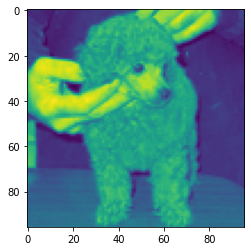

In [17]:
plt.imshow(R.squeeze())

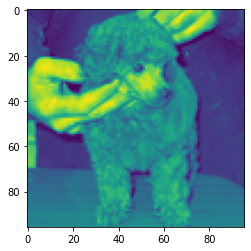

In [19]:
plt.imshow(G.squeeze())

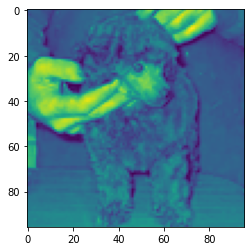

In [18]:
plt.imshow(B.squeeze())

In [ ]:
plt.imshow(R.squeeze())

In [114]:
hat_img_train_set_arr.shape

(96, 96, 3)

In [115]:
R.shape

(96, 96, 1)

In [116]:
B.shape

(96, 96, 1)

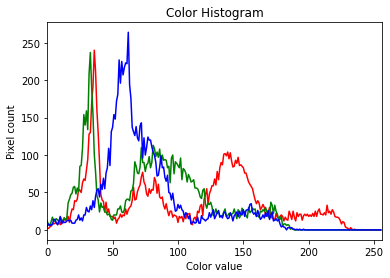

In [20]:
# tuple to select colors of each channel line
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.figure()
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        hat_img_train_set_arr[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.title("Color Histogram")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

plt.show()

In [ ]:

B.squeeze()

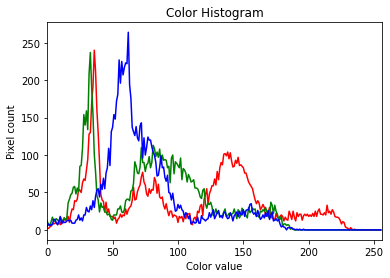

In [33]:
# tuple to select colors of each channel line
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.figure()
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        img_train_set[0].astype('float64').transpose(1,2,0)[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.title("Color Histogram")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

plt.show()

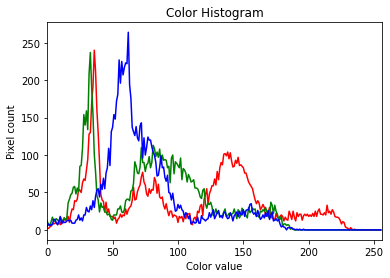

In [27]:
# tuple to select colors of each channel line
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.figure()
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        img_train_set[0].astype('float32').transpose(1,2,0)[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.title("Color Histogram")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

plt.show()

In [ ]:
plt.imshow(G,cmap='gray', vmin=0, vmax=255)

In [111]:
device = get_device()
Gs_blur_strong_tr_dataset = []
for i in range(80000):
  hat_img_train_set_arr_float64 = cv2.GaussianBlur(img_train_set[i], (3,3),0)
  hat_img_train_set_tensor_byte = torch.from_numpy(hat_img_train_set_arr)
# .to(device) X, 데이터 로더에 pin_memory 설정 하면 된다. 
#  print("hat_img_train_set_tensor_float",hat_img_train_set_tensor_float)
#  hat_img_train_set_tensor_normal = hat_img_train_set_tensor_float.div(255.0)
#  print("hat_img_train_set_tensor_normal",hat_img_train_set_tensor_normal)  
  Gs_blur_strong_tr_dataset.append([hat_img_train_set_tensor_byte,0.])

KeyboardInterrupt: ignored

In [ ]:
Gs_blur_strong_tr_dataset[0]

In [ ]:
time.sleep(5.0)

In [ ]:
Gs_blur_strong_val_dataset = []
for j in range(20000):
  hat_img_val_set_arr = cv2.GaussianBlur(img_val_set[j],  (3,3),0)
  hat_img_val_set_tensor_byte = torch.from_numpy(hat_img_val_set_arr) #애초에 ToTensor로 데이터를 불러오지 않으면 from_numpy는 통하지 않는다. 아직 주소가 할당이 안 되었음
#  hat_img_val_set_tensor_normal = hat_img_val_set_tensor_float.div(255.0)
  Gs_blur_strong_val_dataset.append([hat_img_val_set_tensor_byte,0])

In [ ]:
Gs_blur_strong_val_dataset[0]

[tensor([[[166, 157, 152,  ..., 113, 111, 110],
          [164, 153, 150,  ..., 116, 114, 114],
          [160, 144, 143,  ..., 120, 120, 121],
          ...,
          [205, 185, 139,  ..., 174, 168, 169],
          [201, 170, 132,  ..., 174, 172, 175],
          [199, 162, 130,  ..., 173, 174, 178]],
 
         [[193, 188, 185,  ..., 109, 107, 106],
          [193, 185, 184,  ..., 112, 110, 110],
          [189, 176, 175,  ..., 116, 116, 117],
          ...,
          [198, 176, 140,  ..., 177, 172, 172],
          [193, 165, 137,  ..., 177, 175, 178],
          [190, 159, 137,  ..., 176, 177, 181]],
 
         [[221, 219, 218,  ..., 106, 104, 103],
          [222, 218, 217,  ..., 108, 107, 106],
          [219, 209, 207,  ..., 112, 112, 113],
          ...,
          [191, 167, 141,  ..., 180, 175, 174],
          [185, 159, 143,  ..., 181, 178, 181],
          [181, 157, 143,  ..., 179, 179, 184]]], dtype=torch.uint8), 0]

In [ ]:
Gs_blur_strong_val_dataset

[[tensor([[[166, 157, 152,  ..., 113, 111, 110],
           [164, 153, 150,  ..., 116, 114, 114],
           [160, 144, 143,  ..., 120, 120, 121],
           ...,
           [205, 185, 139,  ..., 174, 168, 169],
           [201, 170, 132,  ..., 174, 172, 175],
           [199, 162, 130,  ..., 173, 174, 178]],
  
          [[193, 188, 185,  ..., 109, 107, 106],
           [193, 185, 184,  ..., 112, 110, 110],
           [189, 176, 175,  ..., 116, 116, 117],
           ...,
           [198, 176, 140,  ..., 177, 172, 172],
           [193, 165, 137,  ..., 177, 175, 178],
           [190, 159, 137,  ..., 176, 177, 181]],
  
          [[221, 219, 218,  ..., 106, 104, 103],
           [222, 218, 217,  ..., 108, 107, 106],
           [219, 209, 207,  ..., 112, 112, 113],
           ...,
           [191, 167, 141,  ..., 180, 175, 174],
           [185, 159, 143,  ..., 181, 178, 181],
           [181, 157, 143,  ..., 179, 179, 184]]], dtype=torch.uint8), 0],
 [tensor([[[0, 0, 0,  ..., 0, 0, 0],

In [ ]:
Gs_blur_strong_tr_dataloader = DataLoader(Gs_blur_strong_tr_dataset, batch_size = batch_size, num_workers = 4, pin_memory=True)
Gs_blur_strong_val_dataloader = DataLoader(Gs_blur_strong_val_dataset, batch_size = batch_size, num_workers = 4, pin_memory=True) 


In [ ]:
it = iter(val_dataloader)
a, b = next(it)
a[0].shape

tensor([[[140, 132, 124,  ..., 107, 106, 104],
         [135, 121, 117,  ..., 115, 113, 113],
         [130, 115, 116,  ..., 119, 119, 120],
         ...,
         [213, 197, 138,  ..., 173, 164, 164],
         [213, 180, 129,  ..., 170, 168, 172],
         [207, 155, 122,  ..., 170, 172, 176]],

        [[193, 192, 187,  ..., 110, 109, 106],
         [194, 181, 181,  ..., 118, 116, 116],
         [193, 178, 177,  ..., 122, 122, 123],
         ...,
         [196, 171, 136,  ..., 180, 171, 172],
         [192, 164, 135,  ..., 177, 175, 179],
         [185, 150, 133,  ..., 175, 180, 184]],

        [[248, 251, 251,  ...,  94,  93,  91],
         [250, 252, 252,  ..., 100,  97,  97],
         [252, 255, 255,  ..., 103, 103, 104],
         ...,
         [187, 157, 142,  ..., 188, 178, 175],
         [177, 157, 154,  ..., 184, 181, 184],
         [171, 155, 151,  ..., 179, 181, 188]]], dtype=torch.uint8)

print(torch.from_numpy(cv2.GaussianBlur(train_set_arr[i],(3,3),0).transpose(1,0,2)).float().div(255.0).shape)

Gaussian_blur_strong_tr_arr = np.array([])
y = np.array([])
GS = cv2.GaussianBlur(train_set_arr[1],(3,3),0)
Gaussian_blur_strong_tr_arr = np.append(Gaussian_blur_strong_tr_arr,GS)
print(y.shape)
print(Gaussian_blur_strong_tr_arr.shape)

print(type(GS))

print(Gaussian_blur_strong_tr_arr.shape)

type(Gaussian_blur_strong_tr_arr)

In [ ]:
class DenosingAutoencoder(nn.Module):
  def __init__(self):
    super(DenosingAutoencoder, self).__init__()
    
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 2, stride = 2, padding=0),
    #48 by 48 by 32
        nn.ReLU(True),


        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2, stride = 2, padding = 0),
        nn.ReLU(True),
    # 24 by 24 by 64  

        nn.Conv2d(in_channels =64, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
    # 12 by 12 by 128 

        nn.ReLU(True),

        nn.Conv2d(in_channels = 128, out_channels = 256,  kernel_size = 2, stride = 2, padding=0),
    # 6 by 6 by 256
        nn.ReLU(True),
    )
    self.decoder = nn.Sequential(
 
        nn.ConvTranspose2d(in_channels = 256, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),
    # 12 by 12 by 128  
        nn.ConvTranspose2d(in_channels = 128, out_channels = 64,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),
    # 24 by 24 by 64

        nn.ConvTranspose2d(in_channels = 64, out_channels = 32,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),        
    # 48 by 48 by 32

        nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size = 2, stride = 2, padding=0),
    # 96 by 96 by 3
        nn.Sigmoid())
  
  def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
time.sleep(5.0)

cuda
Epoch : [1/5] 

Training Loss: 15798.447032	 validation Loss 15734.460840
PNSR :43.36 	 SSIM : 0.01
PNSR :8.45 	 SSIM : 0.16
PNSR :0.86 	 SSIM : 0.12
PNSR :3.81 	 SSIM : 0.01
PNSR :-0.83 	 SSIM : 0.01


/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


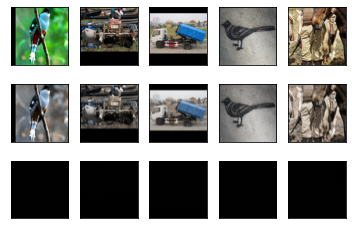

Epoch : [2/5] 



KeyboardInterrupt: ignored

In [ ]:
#Epochs
n_epochs = 5

device = get_device()
print(device)
model_strong = DenosingAutoencoder().double()
optimizer_strong = torch.optim.Adam(model_strong.parameters(), lr=0.001, weight_decay  = 1e-04)
model_strong=model_strong.to(device)

strong_train_loss_graph = np.array([])
strong_val_loss_graph = np.array([])




start = time.time()

for epoch in range(1, n_epochs+1):
    print(f"Epoch : [{epoch}/{n_epochs}]","\n")
    model_strong.eval()
    time.sleep(1.0)
    # monitor training loss
    train_loss = 0.0
    total_train_loss = 0.0
    val_loss = 0.0
    total_val_loss = 0.0

    '''
    Total되는 새로운 변수를 하나 만들어줘야지 val_loss가 제대로 더해진다. 안 하면 이상하게 안 더해진다.
    '''
    #Training
    for i,(tr_img, hat_img) in enumerate(zip(tr_dataloader,Gs_blur_strong_tr_dataloader)):
        tr_images,_ = tr_img
#        print(tr_images_arr.shape)
        hat_tr_images,_ = hat_img
#check   print(type(hat_tr_images))
        hat_tr_images = hat_tr_images.double().to(device) #데이터 형식이 Byte이기 때문에 신경망 성분인 float으로 변환해야 한다.
#check   print(tr_images.shape)
        tr_outputs =model_strong(hat_tr_images)
        optimizer_strong.zero_grad()
#check0. print(hat_tr_images.shape)  
#check   print(tr_outputs.shape)
        tr_images = tr_images.to(device)
        loss = mse_loss(tr_outputs, tr_images).to(device) #여기에 쿠다를 부착하니 성능 급 상승함.
        loss.backward()
        optimizer_strong.step()
        train_loss = loss.clone().detach().item()
        total_train_loss += train_loss

#check1.        print(f"minibatch : {i}, train_loss_added : {total_train_loss/1250}")
    total_train_loss = total_train_loss/len(tr_dataloader)
    strong_train_loss_graph = np.append(strong_train_loss_graph, total_train_loss)

    
    #evaluation
    model_strong.eval()
    time.sleep(1.0)
    with torch.no_grad():   
        optimizer_strong.zero_grad()
        
        for i, (img, hat_img) in enumerate(zip(val_dataloader, Gs_blur_strong_val_dataloader)):
                val_img, _ = img
                hat_val_img,_ = hat_img
                 
                hat_val_img = hat_val_img.double().to(device)
                val_outputs =model_strong(hat_val_img)
#                print('val_outputs shape:',val_outputs.shape )
                val_img = val_img.to(device)
                val_loss = mse_loss(val_outputs, val_img)
                val_loss = val_loss.detach().item()
                total_val_loss += val_loss
#check2.     print(f"val_mini_batch : {i }, val_loss_added : {total_val_loss/313}")                
        total_val_loss = total_val_loss/len(val_dataloader)
        strong_val_loss_graph = np.append(strong_val_loss_graph, total_val_loss)
        print('Training Loss: {:.6f}\t validation Loss {:.6f}'.format(total_train_loss, total_val_loss))
          
#check3.     
        if (epoch)%1 == 0:

          for j in range(5):
            val_ssim = ssim(val_img[j].cpu().numpy().transpose(1, 2, 0), val_outputs[j].cpu().numpy().transpose(1, 2, 0), multichannel=True, gaussian_weights=True, use_sample_covariance=False)
            val_psnr = Get_psnr(val_img[j], val_outputs[j])
            print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(val_psnr,val_ssim))
            
            ax = plt.subplot(3,5,j+1)
            plt.imshow(val_img[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            ax = plt.subplot(3,5,j+5+1)
            plt.imshow(hat_val_img[j].cpu().numpy().astype('uint8').transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            ax = plt.subplot(3, 5, j+5+5+1)
            plt.imshow(val_outputs[j].cpu().numpy().astype('uint8').transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

          plt.show()   

end = time.time()

total_time = (end-start)/60
print("execution time : {:.1f}min".format(total_time))

train모드를 eval로 잠깐 만들었음. 훈련 시간 너무 오래 걸려서 그랬다. 다시 돌려놔야 한다.


tensor([[[  0,   0,   0,  ...,  86,  77,  76],
         [  0,   0,   0,  ...,  86,  78,  82],
         [  0,   0,   0,  ...,  79,  76,  80],
         ...,
         [  0,   0,   0,  ...,  68,  65,  62],
         [  0,   0,   0,  ...,  68,  66,  64],
         [  0,   0,   0,  ...,  67,  66,  68]],

        [[  0,   0,   0,  ..., 171, 155, 149],
         [  0,   0,   0,  ..., 161, 150, 149],
         [  0,   0,   0,  ..., 153, 147, 149],
         ...,
         [  0,   0,   0,  ..., 133, 130, 127],
         [  0,   0,   0,  ..., 133, 129, 128],
         [  0,   0,   0,  ..., 133, 130, 128]],

        [[  0,   0,   0,  ...,  74,  68,  69],
         [  0,   0,   0,  ...,  74,  65,  68],
         [  0,   0,   0,  ...,  72,  67,  69],
         ...,
         [  0,   0,   0,  ...,  49,  48,  45],
         [  0,   0,   0,  ...,  48,  48,  47],
         [  0,   0,   0,  ...,  50,  49,  49]]], device='cuda:0',
       dtype=torch.uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


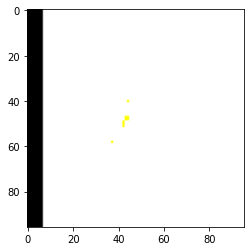

In [ ]:
plt.imshow(hat_val_img[0].cpu().numpy().transpose(1,2,0))

In [ ]:
hat_val_img[0].cpu().numpy().transpose(1,2,0)

array([[[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [126., 123., 120.],
        [115., 112., 110.],
        [114., 111., 109.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [123., 120., 118.],
        [114., 111., 108.],
        [115., 112., 109.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [118., 116., 114.],
        [113., 111., 108.],
        [114., 111., 109.]],

       ...,

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [101.,  96.,  91.],
        [ 98.,  93.,  89.],
        [ 95.,  91.,  87.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [100.,  96.,  91.],
        [ 98.,  93.,  89.],
        [ 96.,  92.,  87.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,  

In [ ]:
plt.imshow(val_img[0].cpu().numpy().astype('uint8').transpose(1, 2, 0))


NameError: ignored

In [ ]:
 hat_val_img,_ = hat_img
 hat_val_img[0]

NameError: ignored

In [ ]:
hat_val_img[0]

tensor([[[  0.0000,   0.0000,   0.0000,  ..., 126.0000, 115.0000, 114.0000],
         [  0.0000,   0.0000,   0.0000,  ..., 122.8750, 113.8750, 114.5000],
         [  0.0000,   0.0000,   0.0000,  ..., 117.5000, 113.1250, 114.2500],
         ...,
         [  0.0000,   0.0000,   0.0000,  ..., 100.8750,  97.6250,  95.2500],
         [  0.0000,   0.0000,   0.0000,  ..., 100.3750,  97.6250,  96.1250],
         [  0.0000,   0.0000,   0.0000,  ..., 100.2500,  97.7500,  97.0000]],

        [[  0.0000,   0.0000,   0.0000,  ..., 123.0000, 112.2500, 111.3750],
         [  0.0000,   0.0000,   0.0000,  ..., 120.1875, 111.1250, 111.6250],
         [  0.0000,   0.0000,   0.0000,  ..., 115.5000, 110.6875, 111.3750],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,  96.0625,  93.3750,  91.0625],
         [  0.0000,   0.0000,   0.0000,  ...,  95.6250,  93.2500,  91.7500],
         [  0.0000,   0.0000,   0.0000,  ...,  95.6250,  93.3750,  92.5000]],

        [[  0.0000,   0.0000,   0.0000,  ...

In [ ]:
val_img[0].cpu().numpy()

array([[[0.        , 0.        , 0.        , ..., 0.3372549 ,
         0.30196078, 0.29803922],
        [0.        , 0.        , 0.        , ..., 0.3372549 ,
         0.30588235, 0.32156863],
        [0.        , 0.        , 0.        , ..., 0.30980392,
         0.29803922, 0.31372549],
        ...,
        [0.        , 0.        , 0.        , ..., 0.26666667,
         0.25490196, 0.24313725],
        [0.        , 0.        , 0.        , ..., 0.26666667,
         0.25882353, 0.25098039],
        [0.        , 0.        , 0.        , ..., 0.2627451 ,
         0.25882353, 0.26666667]],

       [[0.        , 0.        , 0.        , ..., 0.67058824,
         0.60784314, 0.58431373],
        [0.        , 0.        , 0.        , ..., 0.63137255,
         0.58823529, 0.58431373],
        [0.        , 0.        , 0.        , ..., 0.6       ,
         0.57647059, 0.58431373],
        ...,
        [0.        , 0.        , 0.        , ..., 0.52156863,
         0.50980392, 0.49803922],
        [0. 

In [ ]:
val_ssim = ssim(val_img[j].cpu().numpy().transpose(1, 2, 0), val_outputs[j].cpu().numpy().transpose(1, 2, 0), multichannel=True, gaussian_weights=True, use_sample_covariance=False)


In [ ]:
val_ssim

0.1802104514495431

In [ ]:
 aa = val_outputs[0].cpu().numpy().astype('double').transpose(1, 2, 0)
 aa

array([[[0.45878492, 0.44617165, 0.40455192],
        [0.45878847, 0.4465184 , 0.40507919],
        [0.45871959, 0.44610576, 0.40449097],
        ...,
        [0.43207367, 0.41822454, 0.37238172],
        [0.43198173, 0.41785261, 0.37211826],
        [0.43179519, 0.41798396, 0.37207997]],

       [[0.45859847, 0.44598605, 0.40440992],
        [0.45865459, 0.44607661, 0.40500523],
        [0.45855166, 0.44591366, 0.40435729],
        ...,
        [0.43145552, 0.41748701, 0.37202287],
        [0.43125592, 0.41725924, 0.37158406],
        [0.43120585, 0.41724282, 0.37176457]],

       [[0.45844008, 0.4458928 , 0.40419606],
        [0.45844282, 0.44620958, 0.4046603 ],
        [0.45836674, 0.44581572, 0.40411931],
        ...,
        [0.43117278, 0.41741107, 0.37134772],
        [0.43109341, 0.4171194 , 0.37122784],
        [0.43094826, 0.41716482, 0.37108026]],

       ...,

       [[0.46177914, 0.44933361, 0.40823798],
        [0.46183761, 0.44943485, 0.40885491],
        [0.46174612, 0

In [ ]:
val_ssim

0.1852402944182074

In [ ]:
val_img[j].cpu().numpy()

array([[[0.64705882, 0.63921569, 0.62745098, ..., 0.22352941,
         0.25882353, 0.25098039],
        [0.6       , 0.59607843, 0.64705882, ..., 0.20392157,
         0.19607843, 0.19215686],
        [0.65098039, 0.65098039, 0.69803922, ..., 0.20392157,
         0.2       , 0.18431373],
        ...,
        [0.41568627, 0.4627451 , 0.36470588, ..., 0.10196078,
         0.08627451, 0.11764706],
        [0.43137255, 0.45882353, 0.43529412, ..., 0.09019608,
         0.10980392, 0.14117647],
        [0.45098039, 0.38823529, 0.36470588, ..., 0.10196078,
         0.09019608, 0.14117647]],

       [[0.58431373, 0.57647059, 0.56078431, ..., 0.16470588,
         0.2       , 0.18431373],
        [0.53333333, 0.54117647, 0.58039216, ..., 0.14509804,
         0.1372549 , 0.12156863],
        [0.57647059, 0.57254902, 0.61960784, ..., 0.14509804,
         0.14117647, 0.12156863],
        ...,
        [0.36470588, 0.41568627, 0.34509804, ..., 0.09019608,
         0.0745098 , 0.10196078],
        [0.3

In [ ]:
t_val_ssim = ssim(val_img[0].cpu().numpy().astype('uint8').transpose(1, 2, 0), val_outputs[0].cpu().numpy().astype('uint8').transpose(1, 2, 0), multichannel=True, gaussian_weights=True, use_sample_covariance=False)
t_val_ssim

In [ ]:
plt.imshow(val_img[0].cpu().numpy().astype('uint8').transpose(1, 2, 0))

In [ ]:
plt.imshow(hat_val_img[0].cpu().numpy().astype('uint8').transpose(1, 2, 0))

In [ ]:
val_img[0].shape

In [ ]:
val_img[0].cpu().numpy().astype('uint8').transpose(1, 2, 0)

In [ ]:
plt.imshow(hat_val_img[j].cpu().numpy().astype(uint8).transpose(1, 2, 0))

In [ ]:
plt.imshow(hat_val_img[j].cpu().numpy().transpose(1, 2, 0)

In [ ]:
PATH1 = '/content/drive/MyDrive/model/model_strong.pth'
torch.save(model_strong.state_dict(), PATH1)

In [ ]:
a = torch.randn(4)
a


In [ ]:
torch.clamp(a, min=0, max=1)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(strong_train_loss_graph,'r-*')
plt.plot(strong_val_loss_graph, 'b-*')
plt.legend(['strong_train_loss','strong_val_loss'])
plt.title("Stl_10")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig('./strong_loss_graph.png')


# strong test

In [ ]:

Gs_blur_strong_test_dataset = []

for j in range(8000):
  hat_img_test_set_arr = cv2.GaussianBlur(img_test_set_arr[j], (41,41),0)
  hat_img_test_set_tensor_byte = torch.from_numpy(hat_img_test_set_arr)
  hat_img_test_set_tensor_float = hat_img_test_set_tensor_byte.float()
  hat_img_test_set_tensor_normal = hat_img_test_set_tensor_float.div(255.0)
  Gs_blur_strong_test_dataset.append([hat_img_test_set_tensor_normal,0])

Gs_blur_strong_test_dataloader = DataLoader(Gs_blur_strong_test_dataset, batch_size = batch_size, num_workers = 4)

NameError: ignored

# strong graph

# test graph for (average psnr, ssim)

In [ ]:
from skimage.metrics import structural_similarity as ssim

sum_ssim = 0.0
sum_psnr = 0.0
avg_ssim = 0.0
avg_psnr = 0.0

model_strong.eval()
with torch.no_grad():
    optimizer_strong.zero_grad()
    for i, (test_img, hat_test_img) in enumerate(zip(test_dataloader, Gs_blur_strong_test_dataloader)):
        
        strong_test_img, _ = test_img
        strong_test_img = strong_test_img.to(device)
        strong_test_hat_img, _ = hat_test_img
        strong_test_hat_img = strong_test_hat_img.to(device)

        test_outputs = model_strong(strong_test_hat_img)
        
    for j in range(10):
        img1_cpu = strong_test_img[j].cpu().numpy().transpose(1, 2, 0)
        img1_float64 = img1_cpu.astype(np.float64)
        img2_cpu = test_outputs[j].cpu().numpy()
        img2_float64 = img2_cpu.astype(np.float64).transpose(1, 2, 0)
        
        strong_ssim = ssim(img1_float64, img2_float64, multichannel=True, gaussian_weights=True)
        strong_psnr = Get_psnr(strong_test_img[j], test_outputs[j], max_val = 1.0)
        sum_psnr+=strong_psnr
        sum_ssim+=strong_ssim
        print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(strong_psnr,strong_ssim))
        
        ax = plt.subplot(3,10,j+1)
        plt.imshow(strong_test_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10,j+10+1)
        plt.imshow(strong_test_hat_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10, j+20+1)
        plt.imshow(test_outputs[j].cpu().detach().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()   
avg_psnr=sum_psnr/10
avg_ssim=sum_ssim/10

print("avg_psnr : {:.2f}".format(avg_psnr))
print("avg_ssim : {:.2f}".format(avg_ssim))


In [ ]:
data = iter(Gs_blur_strong_val_dataloader)
img,_ = next(data)
img_uint8 = img[0].numpy().astype('uint8')

plt.imshow(img_uint8.transpose(1,2,0))
img[0]

In [ ]:
print(img[0].shape)